# Pendulum SBI

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble.

In [1]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
#from src.scripts import utils

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [16]:
import deepbench
from deepbench.physics_object import Pendulum
print(deepbench.__version__)
STOP

true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
percent_error = 0.1
dL = percent_error * true_L

pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": percent_error,
                "starting_angle_radians": 0.0,
                "acceleration_due_to_gravity": 0.0,
            },
        )

time = np.linspace(0,2,100)
print(time)
one_time = 0.75

pendulum_noisy = pendulum.create_object(time, noiseless=False)
pendulum_noiseless = pendulum.create_object(time, noiseless=True)

pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
pendulum_noiseless_one = pendulum.create_object(one_time, noiseless=True)


plt.clf()
plt.plot(time, pendulum_noisy, color = '#832161')
plt.scatter(time, pendulum_noisy, label = 'Noisy draws', color = '#832161')
plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one', color = '#ED474A')
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

print(pendulum_noisy)
print(pendulum_noiseless)


0.2.01


NameError: name 'STOP' is not defined

In [3]:
# how should this error propagate?

def calc_error_prop(true_L, true_theta, true_a, dthing, time = 0.5, wrt = 'theta_0'):
    if wrt == 'theta_0':
        dx_dthing = true_L * np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * one_time)) * \
              np.cos(np.sqrt(true_a / true_L) * one_time) * dthing
    if wrt == 'L':

        dx_dthing = (0.5 * true_theta * time * np.sqrt(true_a / true_L) * np.sin(time * np.sqrt(true_a / true_L)) * \
             np.cos(true_theta * np.cos(time * np.sqrt(true_a / true_L))) + \
             np.sin(true_theta * np.cos(time * np.sqrt(true_a / true_L)))) * dthing
    return dx_dthing

In [4]:
# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 1000
xs = np.zeros((length_df, 3))
y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=np.pi/100, scale=np.pi/200))
    a_g = abs(rs.normal(loc=10, scale=2))
    xs[r,:] = [length, theta, a_g]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

<Figure size 640x480 with 0 Axes>

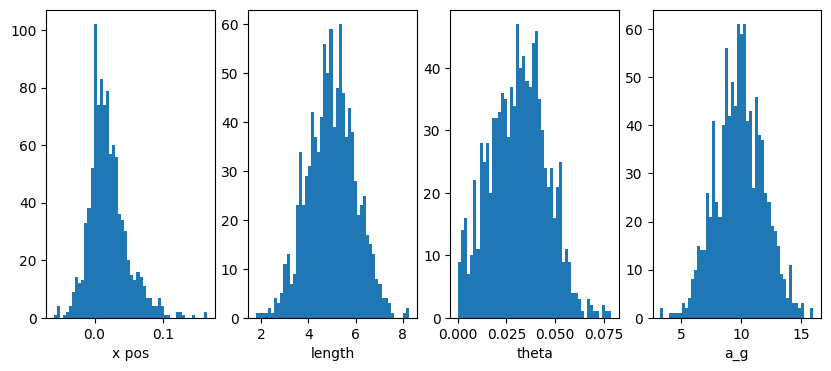

In [5]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(141)
ax.hist(y_noisy, bins=50)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(142)
ax1.hist(xs[:,0], bins=50)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(143)
ax2.hist(xs[:,1], bins=50)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(144)
ax3.hist(xs[:,2], bins=50)
ax3.set_xlabel('a_g')
plt.show()

In [13]:
# we need to normalize everything
xmin = np.min(xs, axis = 0)
xmax = np.max(xs, axis = 0)

norm_xs = (xs - xmin) / (xmax - xmin)
norm_ys = (y_noisy - np.min(y_noisy)) / (np.max(y_noisy) - np.min(y_noisy))

(900, 3) (900,)
(3,)


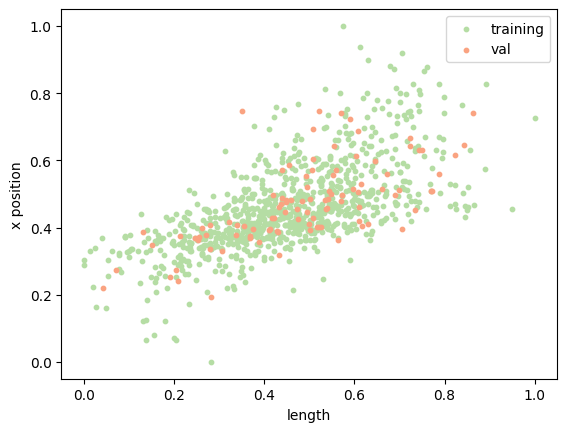

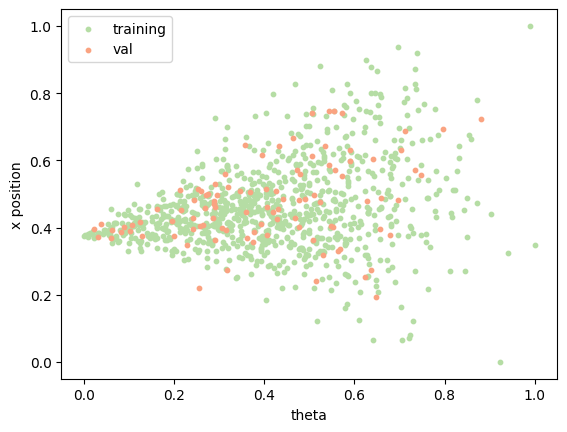

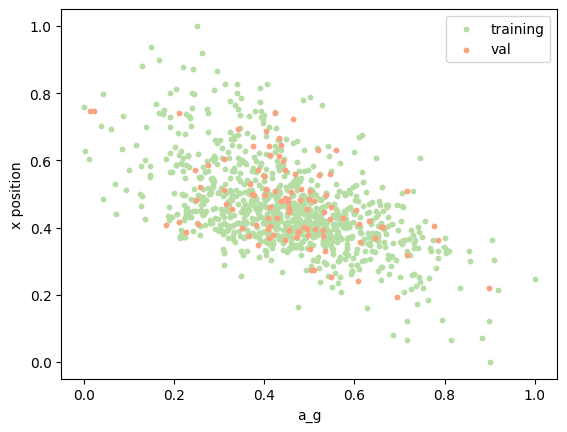

'\nSTOP\n#\n\nscaler = StandardScaler()\nscaler.fit(data)\nStandardScaler()\n>>> print(scaler.mean_)\n[0.5 0.5]\n>>> print(scaler.transform(data))\n\nx_scaler, x_train, x_val = StandardScaler(x_train, x_val)\ny_scaler, y_train, y_val = StandardScaler(y_train, y_val)\n'

In [14]:
# prepare the training, validation, and test set split:

val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_xs, norm_ys, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('length')
plt.ylabel('x position')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('theta')
plt.ylabel('x position')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('a_g')
plt.ylabel('x position')
plt.show()



'''
STOP
#

scaler = StandardScaler()
scaler.fit(data)
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

x_scaler, x_train, x_val = StandardScaler(x_train, x_val)
y_scaler, y_train, y_val = StandardScaler(y_train, y_val)
'''

In [5]:
from sbi import utils, inference, analysis
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.inference.base import infer
import torch

Okay define the priors as uniform distributions.

In [6]:
L_low = [0.3]
L_high = [4.0]

num_dim = 3

low_bounds = torch.tensor([1, np.pi/200, 5])
high_bounds = torch.tensor([10, 3*np.pi/200, 10])

prior = utils.BoxUniform(low = low_bounds, high = high_bounds)
print(prior.sample())

tensor([4.2693, 0.0320, 7.7920])


In [7]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    length, theta, a_g = thetas
    #print('heres what were inputting', thetas, a_g)
    #length_percent_error_all, theta_percent_error_all, a_g_percent_error_all = \
    #    percent_errors
    pendulum = Pendulum(
        pendulum_arm_length=float(length),
        starting_angle_radians=float(theta),
        acceleration_due_to_gravity=float(a_g),
        noise_std_percent={
            "pendulum_arm_length": 0.0,
            "starting_angle_radians": 0.1,
            "acceleration_due_to_gravity": 0.0,
        },
    )
    output = np.array(pendulum.create_object(np.linspace(0,2,100), noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output

def linear_gaussian(theta):
    output = theta + 1.0 + torch.randn_like(theta) * 0.1
    return output

In [8]:
posterior = infer(simulator, prior, "SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 95 epochs.

[0.         0.00197814 0.00355215 0.00518085 0.00828634 0.00966774
 0.00919774 0.01167764 0.0122135  0.01491799 0.01526217 0.01883471
 0.02081954 0.02058699 0.02494227 0.02217283 0.024586   0.02578148
 0.02496162 0.03236943 0.03217136 0.03195316 0.04126398 0.04011
 0.04309779 0.0413649  0.03431496 0.05272706 0.04339631 0.05056688
 0.05622976 0.06275812 0.04611334 0.05582771 0.06824473 0.05559005
 0.05904306 0.05903583 0.07764199 0.07493586 0.06455917 0.06258196
 0.06761967 0.07656815 0.0932496  0.07637863 0.06456149 0.06926533
 0.08423988 0.08916312 0.09140379 0.09752479 0.07640514 0.09955078
 0.07920522 0.0966264  0.10068067 0.10153785 0.09035003 0.08220051
 0.10226456 0.10669141 0.10436796 0.09725107 0.12668815 0.1140712
 0.12901969 0.13200387 0.10876126 0.11896254 0.11521305 0.10945707
 0.11242771 0.14384585 0.12532788 0.12397351 0.14857099 0.10404748
 0.11984162 0.14550079 0.12608133 0.16050655 0.14860422 0.12747917
 0.12439881 0.14937617 0.14112443 0.12644754 0.14633483 0.13729243

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

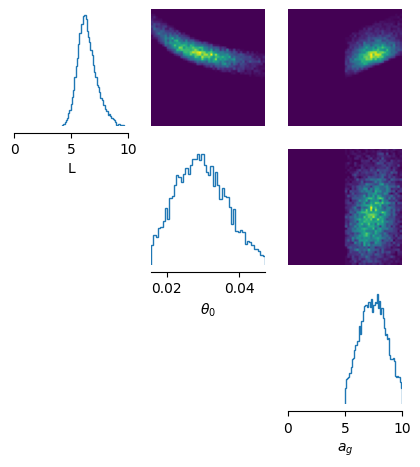

In [15]:
x_o_1 = simulator([5, np.pi/100, 5])
print(x_o_1)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, 
    labels = ['L',r'$\theta_0$','$a_g$'],
    limits = [[0,10],[np.pi/200,3*np.pi/200],[0,10]],
    figsize=(5, 5)
)
